# TimeAtlas

In [3]:
import timeatlas as ta
import pandas as pd
import numpy as np

## Load some data

In [4]:
#s = pd.read_csv("../data/bbdata/2902.csv")
s = pd.read_csv("../data/bbdata/2920.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
s.index = s.index.round("S")

## Create a TimeSeries with the data

In [5]:
ts = ta.TimeSeries(s)
ts

                     values
2018-02-01 00:02:44     0.0
2018-02-01 00:17:44     0.0
2018-02-01 00:32:44     0.0
2018-02-01 00:47:44     0.0
2018-02-01 01:02:44     0.0
...                     ...
2018-02-01 22:47:39     0.0
2018-02-01 23:02:39     0.0
2018-02-01 23:17:39     0.0
2018-02-01 23:32:39     0.0
2018-02-01 23:47:39     0.0

[96 rows x 1 columns]

## Plot the data

<class 'matplotlib.axes._subplots.AxesSubplot'>


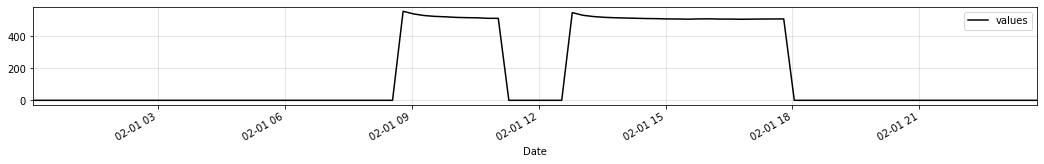

In [6]:
ts.plot()

/Users/frederic.montet/src/heia-fr/timeatlas/src/timeatlas/plots/time_series.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator
  upper_plot.set_xticklabels(x_labels)


<class 'numpy.ndarray'>


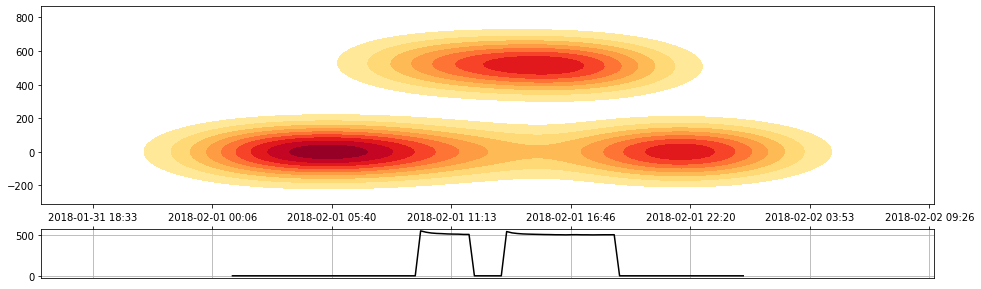

In [7]:
ta.plots.kde(ts)

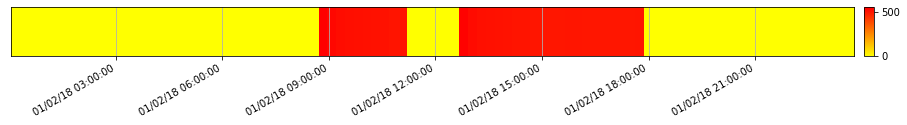

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [8]:
ta.plots.status(ts)

KeyError: 'ci_lower'

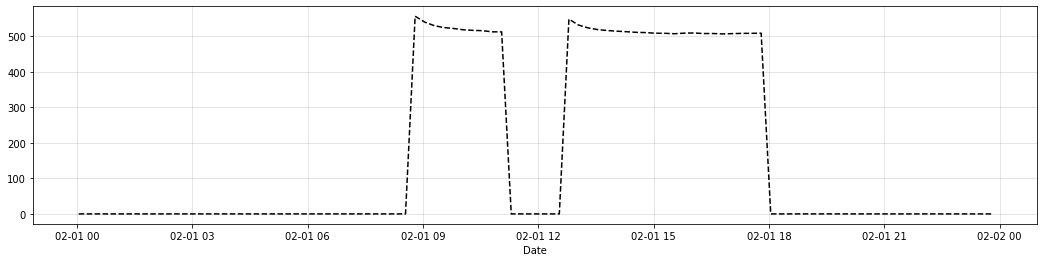

In [10]:
ta.plots.prediction(ts)

## Get some statistics about the TimeSeries

In [5]:
ts.boundaries()

(Timestamp('2018-02-01 00:02:44'), Timestamp('2018-02-01 23:47:39'))

In [6]:
ts.duration()

Timedelta('0 days 23:44:55')

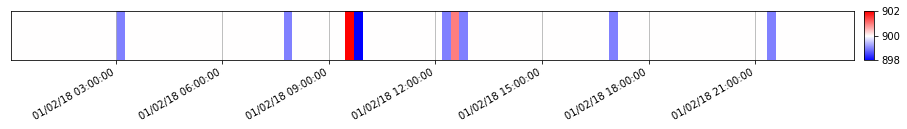

In [8]:
ts.resolution().plot()

In [9]:
None == ts.frequency()

True

Because it doesn't comply with Pandas offset aliases: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
So, let's resample:

In [10]:
ts = ts.resample("15min", method="pad")

In [11]:
ts.frequency()

'15T'

## Empty the TimeSeries

In [12]:
ts.empty() # Empty the time series values but keep the time stamps

                    values
2018-02-01 00:02:44   None
2018-02-01 00:17:44   None
2018-02-01 00:32:44   None
2018-02-01 00:47:44   None
2018-02-01 01:02:44   None
...                    ...
2018-02-01 22:32:44   None
2018-02-01 22:47:44   None
2018-02-01 23:02:44   None
2018-02-01 23:17:44   None
2018-02-01 23:32:44   None

[95 rows x 1 columns]

## Other Functions are available

In [13]:
ts.min()

values    0.0
dtype: float64

In [14]:
ts.max()

values    556.276
dtype: float64

### Resolution to see the consistency of duration between time stamps

In [15]:
res = ts.resolution()
res.describe()

,values
count,94.0
mean,900.0
std,0.0
min,900.0
25%,900.0
50%,900.0
75%,900.0
max,900.0


/Users/frederic.montet/src/heia-fr/timeatlas/src/timeatlas/plots/time_series.py:126: UserWarning: Attempting to set identical bottom == top == 900.0 results in singular transformations; automatically expanding.
  cmap=cmap)


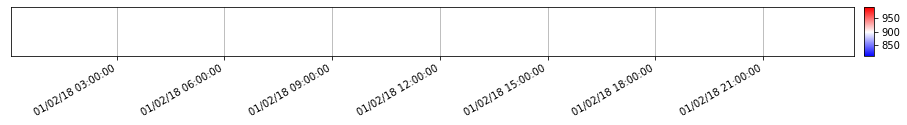

In [16]:
res.plot()

### Apply generic function on time series

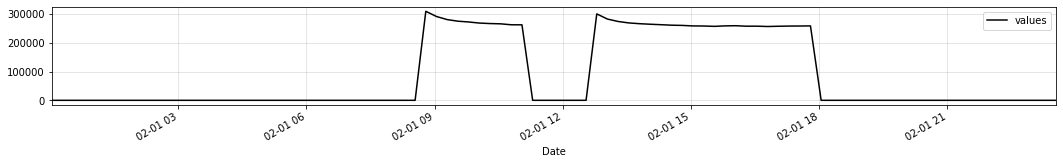

In [17]:
# with one argument
ts.apply(lambda x: x**2).plot()

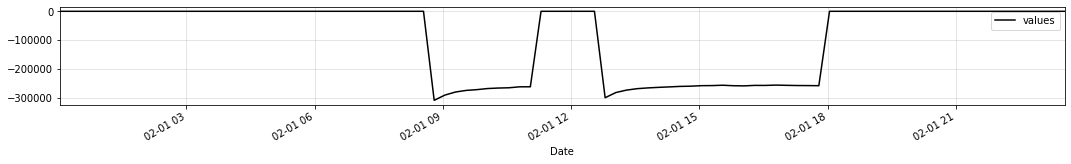

In [18]:
# with two argument (to mix values between two timeseries for instance)
ts.apply(lambda x,y: 0 - x**2 + y, ts).plot()

## Generate a TimeSeries (for testing purposes, etc.)

In [14]:
ts2 = ta.TimeSeries.create("01-2020", "02-2020", "H")
ts2

                    values
2020-01-01 00:00:00    NaN
2020-01-01 01:00:00    NaN
2020-01-01 02:00:00    NaN
2020-01-01 03:00:00    NaN
2020-01-01 04:00:00    NaN
...                    ...
2020-01-31 20:00:00    NaN
2020-01-31 21:00:00    NaN
2020-01-31 22:00:00    NaN
2020-01-31 23:00:00    NaN
2020-02-01 00:00:00    NaN

[745 rows x 1 columns]

In [15]:
ts2 = ts2.fill(np.random.randint(0,100,len(ts2)))
ts2

                     values
2020-01-01 00:00:00      93
2020-01-01 01:00:00      16
2020-01-01 02:00:00      30
2020-01-01 03:00:00      79
2020-01-01 04:00:00      90
...                     ...
2020-01-31 20:00:00      63
2020-01-31 21:00:00      45
2020-01-31 22:00:00      90
2020-01-31 23:00:00      79
2020-02-01 00:00:00      32

[745 rows x 1 columns]

<class 'matplotlib.axes._subplots.AxesSubplot'>


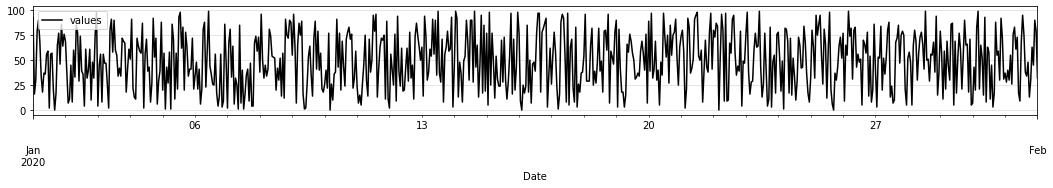

In [16]:
ts2.plot()

## Trim NaNs 

<class 'matplotlib.axes._subplots.AxesSubplot'>


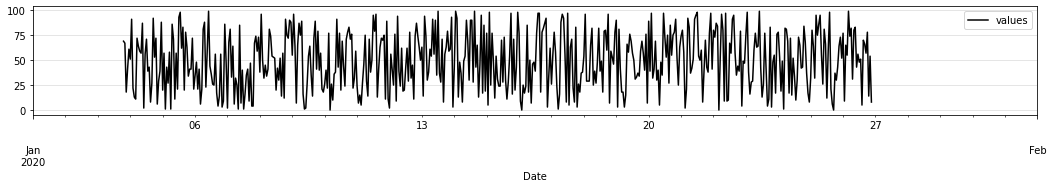

In [17]:
ts2.series[:67] = None
ts2.series[-123:] = None
ts2.plot()

In [18]:
ts2 = ts2.trim()

<class 'matplotlib.axes._subplots.AxesSubplot'>


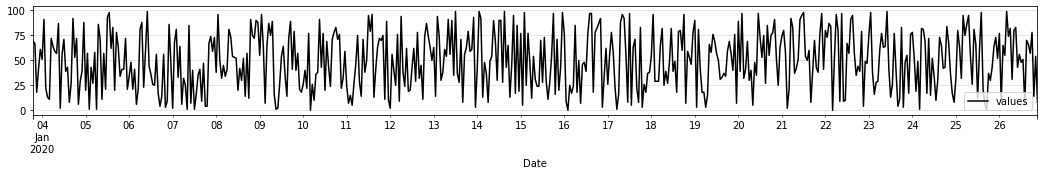

In [19]:
ts2.plot()

## Define a Metadata object

In [20]:
from timeatlas import Metadata, types

# You can use some typed metadata object
my_unit = types.Unit("power", "W", "float")
my_sensor = types.Sensor(2902, "HB/floor2/22-23C/Prises_Power_Tot")

# Or use Python dictionaries
my_location = {
    "building" : "Blue Factory",
    "floor" : "12",
    "room"  : "22C"
}
my_coordinates = {
    "lat" : 46.796611,
    "lon" : 7.147563
}
my_dict = {
    "unit": my_unit,
    "sensor": my_sensor,
    "location": my_location,
    "coordinates": my_coordinates
}

# Create the Metadata object
my_meta = Metadata(my_dict)


## Define a TimeSeries with Metadata

In [21]:
ts.metadata = my_meta

<class 'matplotlib.axes._subplots.AxesSubplot'>


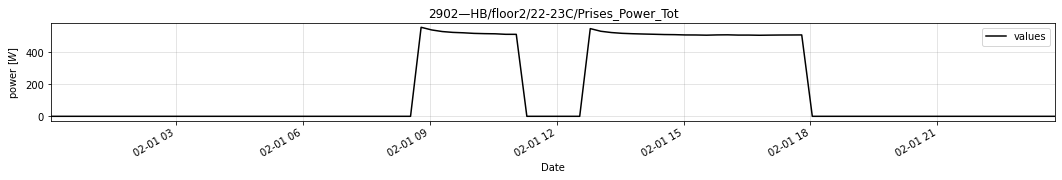

In [22]:
ts.plot()

## Modelling

In [23]:
from timeatlas import models

In [24]:
m1 = models.Prophet()

In [25]:
m1.fit(ts2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [26]:
pts1 = m1.predict("7 day")

<class 'matplotlib.axes._subplots.AxesSubplot'>


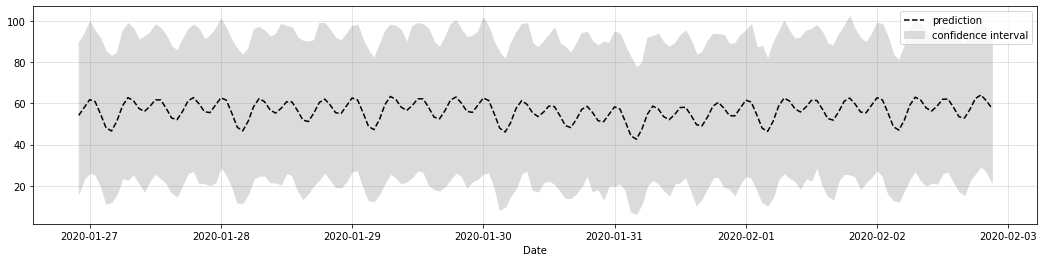

In [27]:
pts1.plot()

## Roadmap

### 2020 - v0.1 - Get Started
    
- Provide data structures specialised for time series uni and multi dimensional
- Provide methods to handle, process, explore and plot time series
- Provide models allowing for prediction, classification, clustering and other machine learning tasks on time series
- Define standard method signatures for time series predictions

- Provide methods to validate models
- Time series labelling
- Provide models allowing for anomaly detections
- Define IO format

- Add synergies between BBData Python Wrapper and TimeAtlas (IO format)
    -> TimeAtlas is generic
    -> BBData Python wrapper will return TA TimeSeries with Metadata

### 2021 - v1.0 - First Production Version

- Model publishing with data from BBData
- Add state of the art machine learning models
- Consolidation
- New features

https://timeatlas.dev/development/roadmap.html